In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the data
df_wind = pd.read_csv('wind.csv')
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Time(year-month-day h:m:s)                     70176 non-null  object 
 1   Wind speed at height of 10 meters (m/s)        70176 non-null  float64
 2   Wind direction at height of 10 meters (˚)      70176 non-null  float64
 3   Wind speed at height of 30 meters (m/s)        70176 non-null  float64
 4   Wind direction at height of 30 meters (˚)      70176 non-null  float64
 5   Wind speed at height of 50 meters (m/s)        70176 non-null  float64
 6   Wind direction at height of 50 meters (˚)      70176 non-null  float64
 7   Wind speed - at the height of wheel hub (m/s)  70176 non-null  float64
 8   Wind speed - at the height of wheel hub (˚)    70176 non-null  float64
 9   Air temperature  (°C)                          701

In [3]:
# extract the data of each hour
df_wind = df_wind[df_wind.index%4==0]

In [4]:
# change the column names
df_wind.columns = ['time', 'speed_10m', 'direction_speed_10m', 
                   'speed_30m', 'direction_speed_30m',
                   'speed_50m', 'direction_speed_50m',
                   'speed_hub', 'direction_speed_hub',
                   'temperature', 'atmosphere', 'humidity', 'power']

# drop the time column
df_wind.drop(columns=['time'], inplace=True)

# describe the wind data
df_wind.describe()

,speed_10m,direction_speed_10m,speed_30m,direction_speed_30m,speed_50m,direction_speed_50m,speed_hub,direction_speed_hub,temperature,atmosphere,humidity,power
count,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000
mean,5.712340,223.050423,6.040569,220.803510,6.169789,222.068659,6.377092,217.127694,8.544979,889.527369,37.569514,23.452132
std,3.118928,73.463343,3.701999,79.713277,3.879296,82.892801,3.909264,85.227213,13.369413,2.438484,18.887011,24.145028
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.014000,861.150000,1.656000,0.000000
25%,3.514000,209.451750,3.291750,192.986250,3.164750,169.658500,3.287000,144.658250,-3.267000,889.550000,22.316500,1.569378
50%,5.386000,235.916500,5.800000,245.441000,5.818500,251.733000,5.898500,248.867000,9.817000,889.750000,34.357000,15.034525
75%,7.215000,275.654750,8.090000,277.826750,8.381250,281.767000,8.573500,279.508250,19.769250,889.925000,51.531000,40.180000
max,23.220000,356.680000,26.735000,358.969000,27.758000,358.000000,29.132000,358.033000,35.630000,918.167000,93.120000,98.090000


In [5]:
# split the data into train set and test set
train_df = df_wind[:14000]
valid_df = df_wind[14000:15750]
test_df = df_wind[15750:17500]

print(train_df.shape, valid_df.shape, test_df.shape)

(14000, 12) (1750, 12) (1750, 12)


In [6]:
# min-max scale or not ?

train_df_normalized = train_df.values
valid_df_normalized = valid_df.values
test_df_normalized = test_df.values

In [7]:
# make the dataset

# set the window size
window_size = 24

class WindDataset(Dataset):
    def __init__(self, data, window_size):
        self.x_data, self.y_data = [], []
        self.len = len(data)-window_size
        
        for i in range(len(data)-window_size):
            feature = data[i:i+window_size, :]
            target = data[i+window_size, [-1]]
            self.x_data.append(feature)
            self.y_data.append(target)
        self.x_data = torch.tensor(self.x_data, dtype=torch.float32)
        self.y_data = torch.tensor(self.y_data, dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
train_dataset = WindDataset(train_df_normalized, window_size)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class cnn_model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=12, out_channels=64, kernel_size=2),  # 24 - 2 + 1 = 23
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1),  # 23 - 2 + 1 = 22
        )
        self.relu = nn.ReLU(inplace=True)
        self.Linear1 = nn.Linear(64 * 22, 64)
        self.Linear2 = nn.Linear(64, 1)

    def forward(self, x):
        # input： batch * seq_len * feature_dim
        # permute: batch * feature_dim * seq_len
        x = x.permute(0, 2, 1)
        
        # conv 1
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        
        # fc
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = x.view(x.shape[0], -1)
        return x

model = cnn_model()
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# train

valid_loss = 1e10

for epoch in range(100):
    
    model.train()
    
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = model(inputs)
        optimizer.zero_grad()
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}; Train Loss: {loss.item()}.')
    
    # last batch inputs
    test_inputs = []
    for i in range(31, -1, -1):
        if i!=0:
            test_input = train_df_normalized[-window_size-i: -i, :].tolist()
        if i==0:
            test_input = train_df_normalized[-window_size-i:, :].tolist()
        test_inputs.append(test_input)
    test_inputs = np.array(test_inputs)
    
    model.eval()

    for i in range(len(valid_df)):
        # last batch size inputs
        input_seq = torch.FloatTensor(test_inputs[-32:])
        
        with torch.no_grad():
            # new prediction, only need the last one
            # output: 1*1
            outputs = model(input_seq.to(device))
            output = outputs[-1].cpu().detach().numpy()
            output = output.astype(np.float32)
            output = output.reshape(1, -1)
            # print(output.shape)
            
            # concat the new prediction to the input sequence
            # init_array: 1*11, new_array: 1*12
            init_array = valid_df_normalized[i, :-1].astype(np.float32)
            init_array = init_array.reshape(1, -1)
            # print(init_array.shape)
            new_array = np.concatenate((init_array, output), axis=1)
            # print(new_array.shape)
        
            # form the new batch size
            # old_batch: (window-1)*12
            # new_one: window*12
            # final_batch: 1*window*12
            old_batch = np.array(test_inputs)[-1][1:]
            # print(old_batch.shape)
            new_batch = np.concatenate((old_batch, new_array), axis=0)
            # print(new_batch.shape)
            final_batch = new_batch.reshape(1, new_batch.shape[0], new_batch.shape[1])
            # print(final_batch.shape)
        
            # iterate the input sequence
            test_inputs = np.concatenate((test_inputs, final_batch), axis=0)
            # print(test_inputs.shape)
            
    pred_outputs = []
    for i in range(len(valid_df_normalized)):
        get_window = test_inputs[32+i]
        get_sample = get_window[-1]
        get_pred = get_sample[-1]
        pred_outputs.append(get_pred)
    pred_outputs = np.array(pred_outputs).reshape(-1, 1)
    actual_values = valid_df_normalized[:, -1].reshape(-1, 1)
    mse = mean_squared_error(pred_outputs, actual_values)
    print(f'Epoch: {epoch+1}; Valid Loss: {mse}.')
    
    if mse < valid_loss:
        valid_loss = mse
        torch.save(model.state_dict(), 'model.pth')
    
print(f'Training finished.')

Epoch: 1; Train Loss: 192.71963500976562.
Epoch: 1; Valid Loss: 568.9648126054713.
Epoch: 2; Train Loss: 207.86170959472656.
Epoch: 2; Valid Loss: 519.0586611639992.
Epoch: 3; Train Loss: 90.82463073730469.
Epoch: 3; Valid Loss: 454.20906331850136.
Epoch: 4; Train Loss: 134.9935760498047.
Epoch: 4; Valid Loss: 564.3657893179778.
Epoch: 5; Train Loss: 114.29088592529297.
Epoch: 5; Valid Loss: 453.9994325067416.
Epoch: 6; Train Loss: 63.186073303222656.
Epoch: 6; Valid Loss: 594.4221650523191.
Epoch: 7; Train Loss: 115.54727935791016.
Epoch: 7; Valid Loss: 966.7230583888006.
Epoch: 8; Train Loss: 93.20738220214844.
Epoch: 8; Valid Loss: 460.10688709149787.
Epoch: 9; Train Loss: 125.78958129882812.
Epoch: 9; Valid Loss: 461.17257151611057.
Epoch: 10; Train Loss: 120.96851348876953.
Epoch: 10; Valid Loss: 455.62491036977224.
Epoch: 11; Train Loss: 186.73519897460938.
Epoch: 11; Valid Loss: 647.6601452657698.
Epoch: 12; Train Loss: 89.81834411621094.
Epoch: 12; Valid Loss: 753.2917766871075

In [10]:
# test

model = cnn_model()
model.load_state_dict(torch.load('model.pth'))
model.to(device)

model.eval()

# last batch inputs
test_inputs = []
for i in range(31, -1, -1):
    if i!=0:
        test_input = valid_df_normalized[-window_size-i: -i, :].tolist()
    if i==0:
        test_input = valid_df_normalized[-window_size-i:, :].tolist()
    test_inputs.append(test_input)
test_inputs = np.array(test_inputs)

for i in range(len(test_df)):
    # last batch size inputs
    input_seq = torch.FloatTensor(test_inputs[-32:])
    
    with torch.no_grad():
        # new prediction, only need the last one
        # output: 1*1
        outputs = model(input_seq.to(device))
        output = outputs[-1].cpu().detach().numpy()
        output = output.astype(np.float32)
        output = output.reshape(1, -1)
        # print(output.shape)
        
        # concat the new prediction to the input sequence
        # init_array: 1*11
        # new_array: 1*12
        
        init_array = test_df_normalized[i, :-1].astype(np.float32)
        init_array = init_array.reshape(1, -1)
        # print(init_array.shape)
        new_array = np.concatenate((init_array, output), axis=1)
        # print(new_array.shape)
        
        # form the new batch size
        # old_batch: window-1*12
        # new_one: window*12
        # final_batch: 1*window*12
        
        old_batch = np.array(test_inputs)[-1][1:]
        # print(old_batch.shape)
        new_batch = np.concatenate((old_batch, new_array), axis=0)
        # print(new_batch.shape)
        final_batch = new_batch.reshape(1, new_batch.shape[0], new_batch.shape[1])
        # print(final_batch.shape)
        
        # iterate the input sequence
        test_inputs = np.concatenate((test_inputs, final_batch), axis=0)
        # print(test_inputs.shape)

pred_outputs = []
for i in range(len(test_df_normalized)):
    get_window = test_inputs[32+i]
    get_sample = get_window[-1]
    get_pred = get_sample[-1]
    pred_outputs.append(get_pred)
pred_outputs = np.array(pred_outputs).reshape(-1, 1)
actual_values = test_df_normalized[:, -1].reshape(-1, 1)

mse = mean_squared_error(pred_outputs, actual_values)
r_2 = r2_score(pred_outputs, actual_values)
mae = mean_absolute_error(pred_outputs, actual_values)
print(mae, mse, r_2)

14.169408859673908 334.9010906937133 -0.7400358080053244


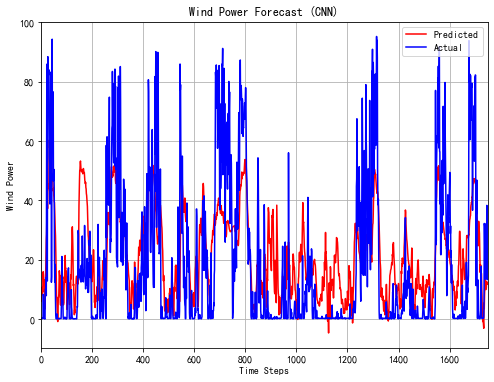

In [18]:
x = np.arange(len(test_df))

plt.figure(figsize=(8, 6))
plt.title('Wind Power Forecast (CNN)')
plt.xlabel('Time Steps')
plt.ylabel('Wind Power')
plt.grid(True)

plt.autoscale(axis='x', tight=True)
plt.plot(x, pred_outputs, color='r')
plt.plot(x, actual_values, color='b')
plt.legend(['Predicted', 'Actual'], loc='upper right')
plt.show()

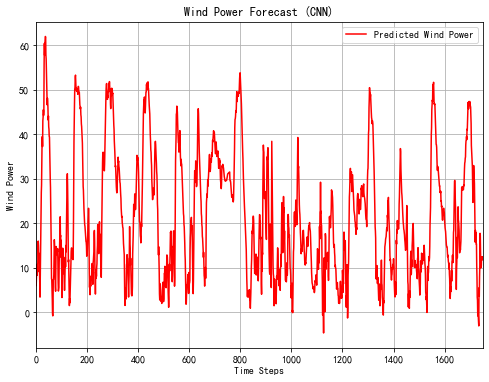

In [19]:
x = np.arange(len(test_df))

plt.figure(figsize=(8, 6))
plt.title('Wind Power Forecast (CNN)')
plt.xlabel('Time Steps')
plt.ylabel('Wind Power')
plt.grid(True)

plt.autoscale(axis='x', tight=True)
plt.plot(x, pred_outputs, color='r')
plt.legend(['Predicted Wind Power'], loc='upper right')
plt.show()

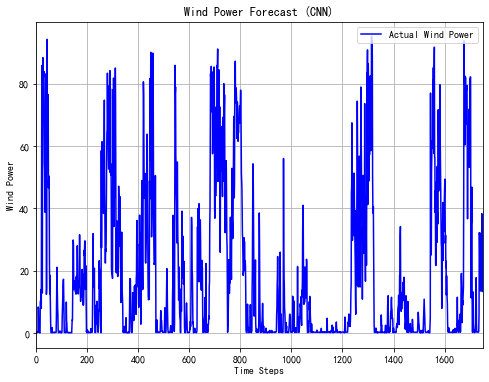

In [20]:
x = np.arange(len(test_df))

plt.figure(figsize=(8, 6))
plt.title('Wind Power Forecast (CNN)')
plt.xlabel('Time Steps')
plt.ylabel('Wind Power')
plt.grid(True)

plt.autoscale(axis='x', tight=True)
plt.plot(x, actual_values, color='b')
plt.legend(['Actual Wind Power'], loc='upper right')
plt.show()